In [11]:
import operator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn import feature_selection
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler, RobustScaler, Imputer, LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

from IPython.core.pylabtools import figsize 
%matplotlib inline

In [12]:
RANDOM_STATE = 42
DATA_EXTERNAL = "../data/external/"
DATA_PROCESSED = "../data/processed/"
DATA_INTERIM = "../data/interim/"

In [13]:
model_dict = {
    'rf':{'pipe':('rf', RandomForestClassifier(random_state=RANDOM_STATE)),
          'params':[{'rf__max_depth':[2, 3, 5, 10, 15], 'rf__n_estimators':[3, 5, 7, 10, 50], 'rf__max_features':[1,2]}],
          'name':'RandomForest'
    },
    'lr':{'pipe':('lr', LogisticRegression()),
        'params':[{'lr__C': [.001, .01, .1, 1, 10, 100, 1000], 'lr__class_weight': [None, 'balanced']}],
        'name':'LogisticRegression'
    },
    'svc':{'pipe':('svc', SVC(kernel='rbf')), 
        'params':[{'svc__C': [1,10,100,1000], 'svc__gamma': [1,0.1,0.001,0.0001]}],
        'name': 'SupportVectorClassifier(RBF)'
    }
}

#### Random Forest

In [14]:
algorithm = 'rf'
model = Pipeline([('imputer', Imputer(missing_values="NaN", strategy="median")), 
                  model_dict[algorithm]['pipe']])
# model = Pipeline([('imputer', Imputer(missing_values="NaN", strategy="median")), ('scaler', StandardScaler()),
#                   model_dict[algorithm]['pipe']])
param_list = [model_dict[algorithm]['params']][0]

folds = 3
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=RANDOM_STATE)

In [15]:
rf_train_scores = []
rf_test_scores = []
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

for i in range(20):
    train = pd.read_csv(DATA_PROCESSED + "train_test_sets/train_{}.csv".format(i), index_col="MUTANT")
    test = pd.read_csv(DATA_PROCESSED + "train_test_sets/test_{}.csv".format(i), index_col="MUTANT")
    X_train = train.drop("TYPE", 1)
    y_train = train.TYPE
    X_test = test.drop("TYPE", 1)
    y_test = test.TYPE
    le = LabelEncoder().fit(y_train)
    gs = GridSearchCV(model, param_list, cv=skf.split(X_train, y_train), 
                      n_jobs=3, scoring='roc_auc', verbose=1, refit=True)
    
    gs.fit(X_train, le.transform(y_train))
    
    
    print("Parameters ({}): {}".format(i, gs.best_params_))
    print("Score train ({}): {}".format(i, gs.best_score_))
    
    
    rf = gs.best_estimator_
    y_pred = rf.predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(le.transform(y_test), y_pred[:, 1])
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    
    test_score = roc_auc_score(le.transform(y_test), y_pred[:, 1])
    
    
    print("Score test ({}): {}".format(i, test_score))
    rf_test_scores.append(test_score)
    rf_train_scores.append(gs.best_score_)
    


Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    8.3s
[Parallel(n_jobs=3)]: Done 150 out of 150 | elapsed:   47.1s finished


Parameters (0): {'rf__max_depth': 15, 'rf__max_features': 2, 'rf__n_estimators': 50}
Score train (0): 0.8669950368750532
Score test (0): 0.8663943223359085
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    8.3s
[Parallel(n_jobs=3)]: Done 150 out of 150 | elapsed:   38.0s finished


Parameters (1): {'rf__max_depth': 15, 'rf__max_features': 2, 'rf__n_estimators': 50}
Score train (1): 0.865398419973372
Score test (1): 0.8730552071735044
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    7.3s
[Parallel(n_jobs=3)]: Done 150 out of 150 | elapsed:   35.8s finished


Parameters (2): {'rf__max_depth': 15, 'rf__max_features': 2, 'rf__n_estimators': 50}
Score train (2): 0.865180274621784
Score test (2): 0.8736563244331935
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    7.3s
[Parallel(n_jobs=3)]: Done 150 out of 150 | elapsed:   35.8s finished


Parameters (3): {'rf__max_depth': 15, 'rf__max_features': 2, 'rf__n_estimators': 50}
Score train (3): 0.8660574704059436
Score test (3): 0.8691488168626885
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    7.2s
[Parallel(n_jobs=3)]: Done 150 out of 150 | elapsed:   35.5s finished


Parameters (4): {'rf__max_depth': 15, 'rf__max_features': 2, 'rf__n_estimators': 50}
Score train (4): 0.8668331978520322
Score test (4): 0.8670634194597495
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    7.1s
[Parallel(n_jobs=3)]: Done 150 out of 150 | elapsed:   35.5s finished


Parameters (5): {'rf__max_depth': 15, 'rf__max_features': 2, 'rf__n_estimators': 50}
Score train (5): 0.8672441222152846
Score test (5): 0.8694542482679518
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    7.3s
[Parallel(n_jobs=3)]: Done 150 out of 150 | elapsed:   35.9s finished


Parameters (6): {'rf__max_depth': 15, 'rf__max_features': 2, 'rf__n_estimators': 50}
Score train (6): 0.8679795308840432
Score test (6): 0.8691444530510966
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    7.4s
[Parallel(n_jobs=3)]: Done 150 out of 150 | elapsed:   36.2s finished


Parameters (7): {'rf__max_depth': 15, 'rf__max_features': 2, 'rf__n_estimators': 50}
Score train (7): 0.8652701418789652
Score test (7): 0.8680013557026033
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    9.6s
[Parallel(n_jobs=3)]: Done 150 out of 150 | elapsed:   41.5s finished


Parameters (8): {'rf__max_depth': 15, 'rf__max_features': 2, 'rf__n_estimators': 50}
Score train (8): 0.8665384389656364
Score test (8): 0.8714122807925991
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    7.0s
[Parallel(n_jobs=3)]: Done 150 out of 150 | elapsed:   34.6s finished


Parameters (9): {'rf__max_depth': 15, 'rf__max_features': 2, 'rf__n_estimators': 50}
Score train (9): 0.8678378791482834
Score test (9): 0.8662535827734067
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    7.0s
[Parallel(n_jobs=3)]: Done 150 out of 150 | elapsed:   34.7s finished


Parameters (10): {'rf__max_depth': 15, 'rf__max_features': 2, 'rf__n_estimators': 50}
Score train (10): 0.8675224292283426
Score test (10): 0.8665412048705095
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    6.9s
[Parallel(n_jobs=3)]: Done 150 out of 150 | elapsed:   34.6s finished


Parameters (11): {'rf__max_depth': 15, 'rf__max_features': 2, 'rf__n_estimators': 50}
Score train (11): 0.8663365654381395
Score test (11): 0.871944878243903
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    7.0s
[Parallel(n_jobs=3)]: Done 150 out of 150 | elapsed:   34.8s finished


Parameters (12): {'rf__max_depth': 15, 'rf__max_features': 2, 'rf__n_estimators': 50}
Score train (12): 0.8683850513323629
Score test (12): 0.8661842663259884
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    7.1s
[Parallel(n_jobs=3)]: Done 150 out of 150 | elapsed:   35.2s finished


Parameters (13): {'rf__max_depth': 15, 'rf__max_features': 2, 'rf__n_estimators': 50}
Score train (13): 0.8648490412307637
Score test (13): 0.872340595406243
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    6.9s
[Parallel(n_jobs=3)]: Done 150 out of 150 | elapsed:   34.8s finished


Parameters (14): {'rf__max_depth': 15, 'rf__max_features': 2, 'rf__n_estimators': 50}
Score train (14): 0.8672170781932789
Score test (14): 0.8678763718898659
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    6.9s
[Parallel(n_jobs=3)]: Done 150 out of 150 | elapsed:   34.5s finished


Parameters (15): {'rf__max_depth': 15, 'rf__max_features': 2, 'rf__n_estimators': 50}
Score train (15): 0.8662747592270861
Score test (15): 0.8694296232702865
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    7.0s
[Parallel(n_jobs=3)]: Done 150 out of 150 | elapsed:   35.0s finished


Parameters (16): {'rf__max_depth': 15, 'rf__max_features': 2, 'rf__n_estimators': 50}
Score train (16): 0.8665070197059863
Score test (16): 0.8718939464550581
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    7.1s
[Parallel(n_jobs=3)]: Done 150 out of 150 | elapsed:   35.1s finished


Parameters (17): {'rf__max_depth': 15, 'rf__max_features': 2, 'rf__n_estimators': 50}
Score train (17): 0.867862106844245
Score test (17): 0.8643433308876515
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    7.0s
[Parallel(n_jobs=3)]: Done 150 out of 150 | elapsed:   34.6s finished


Parameters (18): {'rf__max_depth': 15, 'rf__max_features': 2, 'rf__n_estimators': 50}
Score train (18): 0.8656851938659258
Score test (18): 0.8707273571066354
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    7.0s
[Parallel(n_jobs=3)]: Done 150 out of 150 | elapsed:   34.8s finished


Parameters (19): {'rf__max_depth': 15, 'rf__max_features': 2, 'rf__n_estimators': 50}
Score train (19): 0.8672115463020248
Score test (19): 0.8696192056570577


In [7]:
pd.DataFrame(tprs).to_csv("../results/humsavar/rf_cons_only_tprs.csv", index=False)
pd.Series(aucs).to_csv("../results/humsavar/rf_cons_only_aucs.csv", index=False)

In [ ]:
pd.DataFrame(tprs).to_csv("../results/humsavar/rf_tprs.csv", index=False)
pd.Series(aucs).to_csv("../results/humsavar/rf_aucs.csv", index=False)

In [8]:
print("MEAN TRAIN: ", np.mean(rf_train_scores))
print("STDDEV TRAIN: ", np.std(rf_train_scores))
print("MEAN TEST: ", np.mean(rf_test_scores))
print("STDDEV TEST: ", np.std(rf_test_scores))

MEAN TRAIN:  0.849761531399
STDDEV TRAIN:  0.0011997633817
MEAN TEST:  0.84948929596
STDDEV TEST:  0.00309436927093


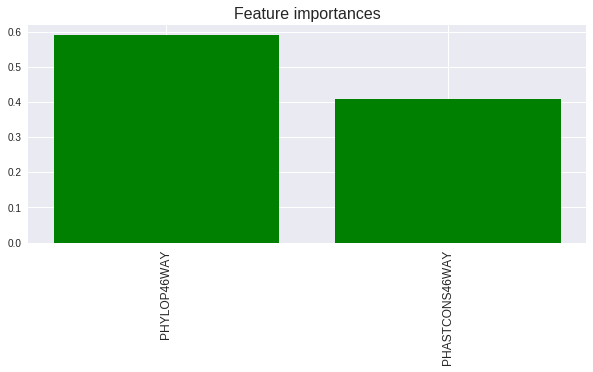

In [9]:
importances = [(X_train.columns[e], x) for e, x in enumerate(rf.steps[1][1].feature_importances_)]
importances.sort(key=operator.itemgetter(1), reverse=True)
figsize(10,4)
plt.title("Feature importances", fontsize=16)
plt.bar(np.arange(len(importances)), [y for x, y in importances], color="g", align="center")
plt.xticks(range(len(importances)), [x for x, y in importances], rotation='vertical', fontsize=12)
# plt.xlim([0, range(len(importances))])
plt.show()

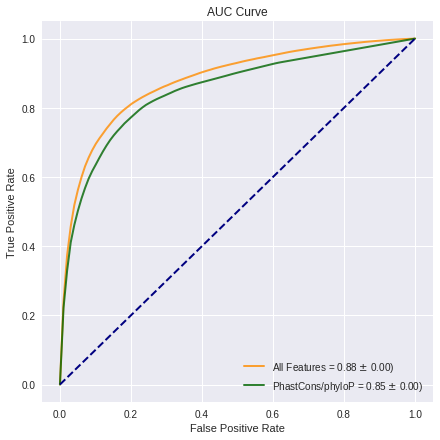

In [10]:
figsize(7,7)

rf_tprs = pd.read_csv("../results/humsavar/rf_tprs.csv")
rf_aucs = pd.read_csv("../results/humsavar/rf_aucs.csv")

lr_tprs = pd.read_csv("../results/humsavar/rf_cons_only_tprs.csv")
lr_aucs = pd.read_csv("../results/humsavar/rf_cons_only_aucs.csv")

def plot_auc_curve(tprs, aucs, color, label):
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    plt.plot(mean_fpr, mean_tpr, color=color,
             label=label % (mean_auc, std_auc),
             lw=2, alpha=.8)
    
plot_auc_curve(rf_tprs, rf_aucs, 'darkorange', r'All Features = %0.2f $\pm$ %0.2f)')
plot_auc_curve(lr_tprs, lr_aucs, 'darkgreen', r'PhastCons/phyloP = %0.2f $\pm$ %0.2f)')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC Curve')
plt.legend(loc="lower right")

plt.show()